# Computational intelligence Project_1

### 1. Import the MNIST dataset

In [1]:
import numpy as np
import tensorflow as tf

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
# x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0
x_train, x_test = x_train.astype("float32") / 255.0, x_test.astype("float32") / 255.0

x_train, y_train = x_train[:6000], y_train[:6000]

print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

In [3]:
import sys
import sklearn
import matplotlib
import numpy as np

print('Python: {}'.format(sys.version))
print('Sklearn: {}'.format(sklearn.__version__))
print('Matplotlib: {}'.format(matplotlib.__version__))
print('NumPy: {}'.format(np.__version__))

Python: 3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]
Sklearn: 0.20.3
Matplotlib: 3.0.3
NumPy: 1.16.2


### 2. Showing some images from train dataset

In [4]:
import matplotlib.pyplot as plt

# python magic function
%matplotlib inline

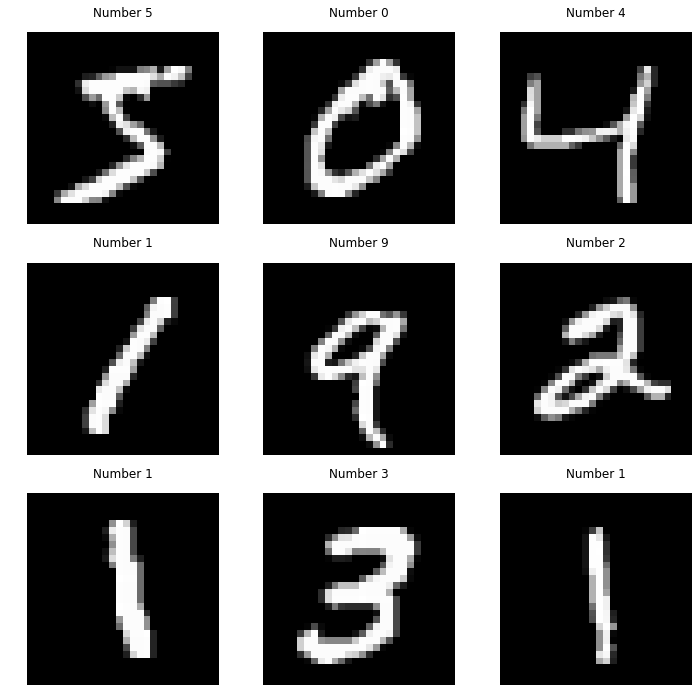

In [5]:
import warnings
warnings.filterwarnings("ignore")

# create figure with 3x3 subplots using matplotlib.pyplot
fig, axs = plt.subplots(3, 3, figsize = (12, 12))
plt.gray()

# loop through subplots and add mnist images
for i, ax in enumerate(axs.flat):
    ax.matshow(x_train[i])
    ax.axis('off')
    ax.set_title('Number {}'.format(y_train[i]))
    
# display the figure
fig.show()

### 3. Preprocessing the MNIST images

In [6]:
# preprocessing the images

# convert each image to 1 dimensional array
X = x_train.reshape(len(x_train),-1)
Y = y_train

# normalize the data to 0 - 1
X = X.astype(float) / 255.

print(X.shape)
print(X[0].shape)

(60000, 784)
(784,)


### 4. K-Means Clustering

In this section, we first trained the kmeans model. It took about 124 seconds. Depending on the time taken, we will use another variety of kmeans, MiniBatchKMeans, to speed up the next training.

MiniBatchKMeans is to reduce the computational cost by not using all the dataset each iteration but a subsample of a fixed size. This strategy reduces the number of distance computations per iteration at the cost of lower cluster quality

In the following link you can see a comparison between MiniBatchKMeans and kmeans.
https://upcommons.upc.edu/bitstream/handle/2117/23414/R13-8.pdf


In [7]:
import time
from sklearn.cluster import MiniBatchKMeans, KMeans

n_digits = len(np.unique(y_test))
print("K = %d\n" %n_digits)


# Initialize KMeans model
kmeans =  KMeans(n_clusters = n_digits)

# Fit the model to the training data
t0 = time.time()
print(kmeans.fit(X))
t_batch = time.time() - t0

#print time of training
print("\ntime of KMeans is : %.2f\n" %t_batch)


# Initialize KMeans model
kmeans =  MiniBatchKMeans(n_clusters = n_digits)

# Fit the model to the training data
t0 = time.time()
print(kmeans.fit(X))
t_batch = time.time() - t0

#print time of training
print("\ntime of MiniBatchKMeans is : %.2f" %t_batch)

K = 10

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

time of KMeans is : 124.27

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=10,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

time of MiniBatchKMeans is : 0.50


In [8]:
kmeans.labels_

array([0, 4, 9, ..., 3, 0, 1])

### 5. Assigning Cluster Labels

In [9]:
def infer_cluster_labels(kmeans, actual_labels):
    """
    Associates most probable label with each cluster in KMeans model
    returns: dictionary of clusters assigned to each label
    """

    inferred_labels = {}

    for i in range(kmeans.n_clusters):

        # find index of points in cluster
        labels = []
        index = np.where(kmeans.labels_ == i)

        # append actual labels for each point in cluster
        labels.append(actual_labels[index])

        # determine most common label
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))

        # assign the cluster to a value in the inferred_labels dictionary
        if np.argmax(counts) in inferred_labels:
            # append the new number to the existing array at this slot
            inferred_labels[np.argmax(counts)].append(i)
        else:
            # create a new array in this slot
            inferred_labels[np.argmax(counts)] = [i]

        #print(labels)
        #print('Cluster: {}, label: {}'.format(i, np.argmax(counts)))
        
    return inferred_labels  

def infer_data_labels(X_labels, cluster_labels):
    """
    Determines label for each array, depending on the cluster it has been assigned to.
    returns: predicted labels for each array
    """
    
    # empty array of len(X)
    predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)
    
    for i, cluster in enumerate(X_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key
                
    return predicted_labels

In [10]:
# test the infer_cluster_labels() and infer_data_labels() functions
cluster_labels = infer_cluster_labels(kmeans, Y)
X_clusters = kmeans.predict(X)
predicted_labels = infer_data_labels(X_clusters, cluster_labels)
print (predicted_labels[:20])
print (Y[:20])

[0 0 4 1 7 8 9 0 1 7 9 8 3 6 1 7 1 8 1 7]
[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]


### 6. Calculating Purity and Rand-Index for diffrent parameters

In [29]:
import numpy as np
from sklearn import metrics

def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 

In [30]:
import numpy as np
from scipy.misc import comb
import warnings

warnings.filterwarnings("ignore")
def rand_index_score(clusters, classes):
    tp_plus_fp = comb(np.bincount(clusters), 2).sum()
    tp_plus_fn = comb(np.bincount(classes), 2).sum()
    A = np.c_[(clusters, classes)]
    tp = sum(comb(np.bincount(A[A[:, 0] == i, 1]), 2).sum()
             for i in set(clusters))
    fp = tp_plus_fp - tp
    fn = tp_plus_fn - tp
    tn = comb(len(A), 2) - tp - fp - fn
    return (tp + tn) / (tp + fp + fn + tn)

In [31]:
import time
from sklearn.cluster import MiniBatchKMeans

def kmeans_whit_differnt_parameters(estimator = MiniBatchKMeans()):
    
    t0 = time.time()
    estimator.fit(X)
    t_batch = time.time() - t0
  
    # determine predicted labels
    cluster_labels = infer_cluster_labels(estimator, Y)
    predicted_Y = infer_data_labels(estimator.labels_, cluster_labels)
    
    # print time
    print("time : %.2f" %t_batch)
    
    # calculate and print accuracy
    print('purity : %.2f' %(purity_score(Y, predicted_Y)))
    print('rand_index : %.2f\n' %(rand_index_score(Y, predicted_Y)))

### 6.1 n_clusters , default = 8

The number of clusters to form as well as the number of centroids to generate.

According to the results, we are the most accurate for n_clusters = 128 .

In [32]:
clusters = [10, 20, 36, 64 , 128]

# test different numbers of clusters
for n_clusters in clusters:
    estimator = MiniBatchKMeans(n_clusters = n_clusters)
    print('n_clusters : {}'.format(estimator.n_clusters))
    kmeans_whit_differnt_parameters(estimator)

n_clusters : 10
time : 0.97
purity : 0.54
rand_index : 0.86

n_clusters : 20
time : 1.23
purity : 0.67
rand_index : 0.90

n_clusters : 36
time : 2.31
purity : 0.76
rand_index : 0.92

n_clusters : 64
time : 2.25
purity : 0.80
rand_index : 0.94

n_clusters : 128
time : 4.23
purity : 0.85
rand_index : 0.95



### 6.2 init , default = ’k-means++’

Method for initialization:

‘k-means++’ : selects initial cluster centers for k-mean clustering in a smart way to speed up convergence. See section Notes in k_init for more details.
‘random’: choose n_clusters observations (rows) at random from data for the initial centroids.

Here the results are the same for both modes and only in ‘k-means++’ mode purity is better.

In [37]:
init_state = ['k-means++', 'random']

# test different state of initial
for init in init_state:
    estimator = MiniBatchKMeans(n_clusters = 128 , init = init)
    print('init : %s' %(init))
    kmeans_whit_differnt_parameters(estimator)

init : k-means++
time : 3.89
purity : 0.86
rand_index : 0.95

init : random
time : 3.57
purity : 0.85
rand_index : 0.95



### 6.3 n_init , default = 3

Number of random initializations that are tried. In contrast to KMeans, the algorithm is only run once, using the best of the n_init initializations as measured by inertia.

Here, the same results are obtained for different modes, but less time is spent for n_init = 3.

In [38]:
n_inits = [2 , 3 , 6]

# test different numbers of initial
for n_init in n_inits:
    estimator = MiniBatchKMeans(n_clusters = 128, init = 'k-means++', n_init = n_init)
    print('n_init : %d' %(n_init))
    kmeans_whit_differnt_parameters(estimator)

n_init : 2
time : 4.15
purity : 0.85
rand_index : 0.95

n_init : 3
time : 3.67
purity : 0.86
rand_index : 0.95

n_init : 6
time : 4.19
purity : 0.86
rand_index : 0.95



### 6.4 random_state , default = None

Determines random number generation for centroid initialization and random reassignment .

According to the results below, the ratings are the same for both modes, but for random_state = 10, less time is spent.

In [41]:
random_states = [10 , 20]

# test different state for random
for random_state in random_states:
    estimator = MiniBatchKMeans(n_clusters = 128 , init = 'k-means++' , n_init = 3 , random_state = random_state)
    print('random_state : %d' %(random_state))
    kmeans_whit_differnt_parameters(estimator)

random_state : 10
time : 3.70
purity : 0.86
rand_index : 0.95

random_state : 20
time : 4.03
purity : 0.86
rand_index : 0.95



### 6.5 batch_size , default = 100

Size of the mini batches.

Here, the same results are obtained for different modes, but less time is spent for batch_size = 100.

In [42]:
batch_size_array = [80 , 100 , 120 , 150]

# test different size of batch
for batch_size in batch_size_array:
    estimator = MiniBatchKMeans(n_clusters = 128, init = 'k-means++', n_init = 3, random_state = 10, batch_size = batch_size)
    print('batch_size : %d' %(batch_size))
    kmeans_whit_differnt_parameters(estimator)

batch_size : 80
time : 4.08
purity : 0.86
rand_index : 0.95

batch_size : 100
time : 3.54
purity : 0.86
rand_index : 0.95

batch_size : 120
time : 3.73
purity : 0.86
rand_index : 0.95

batch_size : 150
time : 4.01
purity : 0.86
rand_index : 0.95



### 6.6 max_iter , default = 100

Maximum number of iterations over the complete dataset before stopping independently of any early stopping criterion heuristics.

Here, too, it is more desirable results for max_iter = 100.

In [45]:
max_iter_array = [70 , 100 , 150]

# test different numbers of max_iteration
for max_iter in max_iter_array:
    estimator = MiniBatchKMeans(n_clusters = 128, init = 'k-means++', n_init = 3, random_state = 10, batch_size = 100, max_iter = max_iter)
    print('max_iter : %d' %(max_iter))
    kmeans_whit_differnt_parameters(estimator)

max_iter : 70
time : 3.76
purity : 0.86
rand_index : 0.95

max_iter : 100
time : 3.55
purity : 0.86
rand_index : 0.95

max_iter : 150
time : 3.60
purity : 0.86
rand_index : 0.95



### 6.7 init_size , default = None

Number of samples to randomly sample for speeding up the initialization (sometimes at the expense of accuracy): the only algorithm is initialized by running a batch KMeans on a random subset of the data.

Here, too, for init_size = 300, the results are more favorable.

In [46]:
init_size_array = [250 , 300 , 400]

# test different size of initial
for init_size in init_size_array:
    estimator = MiniBatchKMeans(n_clusters = 128, init = 'k-means++', n_init = 3, random_state = 10, batch_size = 100, max_iter = 100, init_size = init_size)
    print('init_size : %d' %(init_size))
    kmeans_whit_differnt_parameters(estimator)

init_size : 250
time : 3.73
purity : 0.86
rand_index : 0.95

init_size : 300
time : 3.62
purity : 0.86
rand_index : 0.95

init_size : 400
time : 4.87
purity : 0.85
rand_index : 0.95



### 7. Visualizing instances of cluster centroid

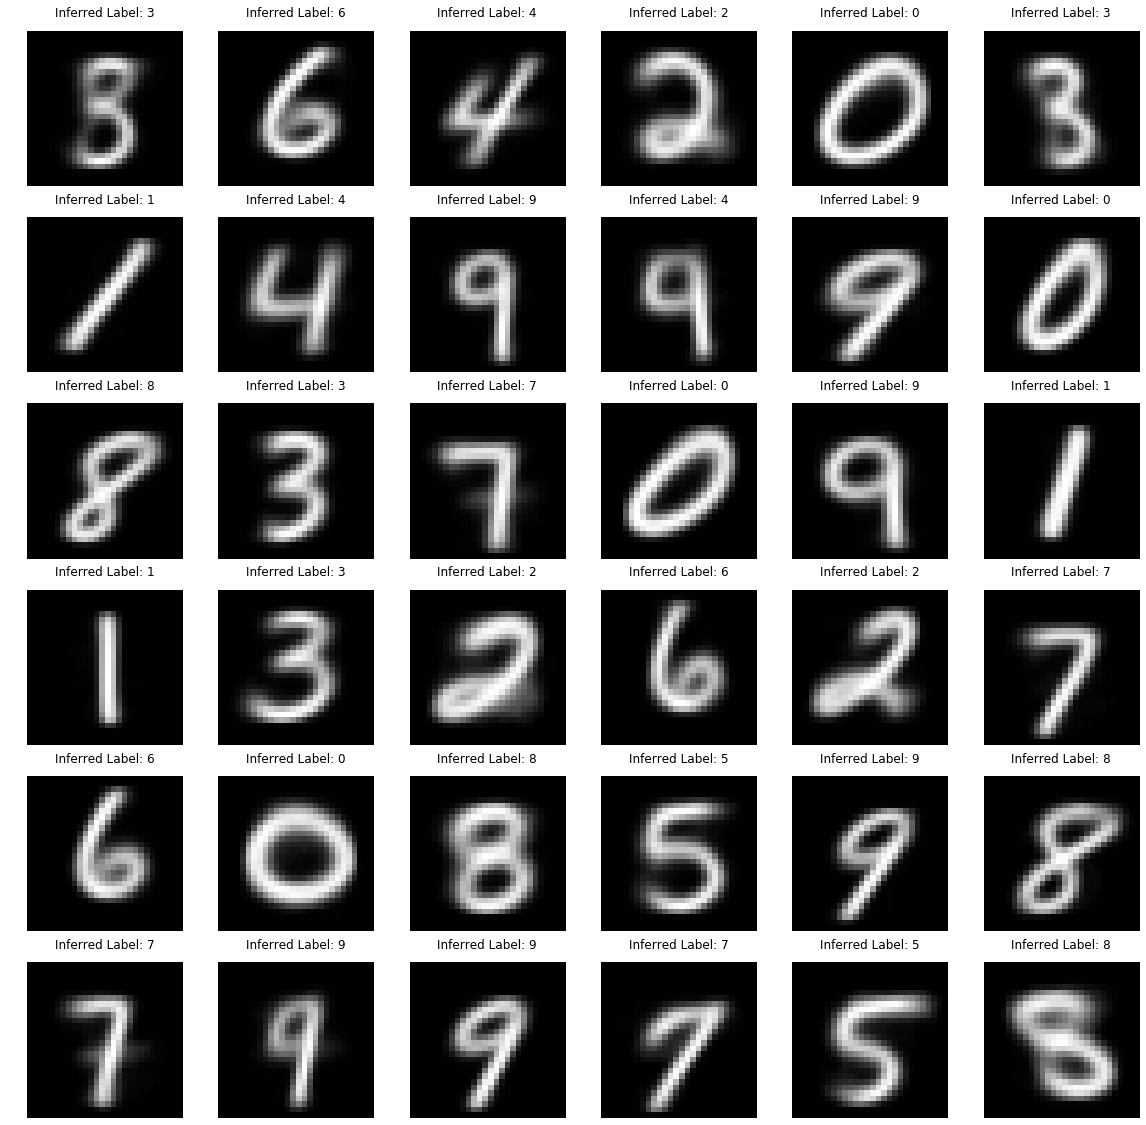

In [55]:
import warnings
from sklearn.cluster import MiniBatchKMeans

warnings.filterwarnings("ignore")

# Initialize and fit KMeans algorithm
kmeans = MiniBatchKMeans(n_clusters = 128, init = 'k-means++', n_init = 3, random_state = 10, batch_size = 100, max_iter = 100, init_size = 300)
kmeans.fit(X)

# record centroid values
centroids = kmeans.cluster_centers_

# reshape centroids into images
images = centroids.reshape(128, 28, 28)
images *= 255
images = images.astype(np.uint8)

# determine cluster labels
cluster_labels = infer_cluster_labels(kmeans, Y)

# create figure with subplots using matplotlib.pyplot
fig, axs = plt.subplots(6, 6, figsize = (20, 20))
plt.gray()

# loop through subplots and add centroid images
for i, ax in enumerate(axs.flat):
    
    # determine inferred label using cluster_labels dictionary
    for key, value in cluster_labels.items():
        if i in value:
            ax.set_title('Inferred Label: {}'.format(key))
    
    # add image to subplot
    ax.matshow(images[i])
    ax.axis('off')
    
# display the figure
fig.show()